# Notebook to show how we computed PPH and SigSVR in Australia with the LSR data there.  
## Note that the reports in Australia are much more sparse than the reports in the US so we had to adjust some parameters

In [1]:
# install metpy version 1.6.3 for this notebook only
!uv pip install metpy==1.6.3

Audited 1 package in 64ms


In [2]:
# all the imports you should need for this notebook

import xarray as xr
import metpy
import numpy as np
# Add colorbar with same height as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import requests
from typing import Optional, Union, Literal
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
from scipy.ndimage import gaussian_filter
import requests
import matplotlib.colors as mcolors
from itertools import product

# added by amy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.lines import Line2D



# Functions to read in and plot the data in Australia

In [3]:
# This is modified from the original code for CONUS to work with Australian LSR data
def extract_lsr_data_australia(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    aus_file = "gs://extremeweatherbench/datasets/AustralianLSRData_2020-2024.csv"

    # Read the CSV files with all columns to identify report types
    try:
        df = pd.read_csv(aus_file, delimiter=',', engine='python', storage_options=dict(token="anon"), parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()

    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        print(f'No LSR data found for {date}')
        return pd.DataFrame()
    return df


# You only need to run the code below ONCE to fix the files

In [4]:
# This only needs to be run ONCE to fix the broken datetimes in the hail and tornado data.
# It will create new files with the fixed datetimes and a combined file for sharing.
# If you run this again, it will overwrite the existing files, so be careful!

# the combined file is uploaded to the google bucket in the ExtremeWeatherBench project
# and can be accessed at gs://extremeweatherbench/datasets/AustralianLSRData_2020-2024.csv

# fix the broken datetimes in the australian hail data
hail_file = '/home/amy/AustralianHailData_2020-2024_cleaned.csv'
df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
df_hail = df_hail[['UTC', 'Latitude', 'Longitude', 'Nearest town', 'State', "Hail size"]]
# rename the date column to match the tornado data
df_hail.rename(columns={'UTC': 'Date/Time UTC'}, inplace=True)

# Crate a report_type column
df_hail['report_type'] = 'hail'

# save the new file
new_hail_file = '/home/amy/AustralianHailData_2020-2024_cleaned_fixed.csv'
df_hail.to_csv(new_hail_file, index=False)

# fix the broken date-times in the tornado data
tor_file = '/home/amy/AustralianTornadoData_2020-2024_cleaned.csv'
df_tor = pd.read_csv(tor_file, delimiter=',', engine='python', parse_dates=['Date/Time UTC'], infer_datetime_format=True)
df_tor = df_tor[['Date/Time UTC', 'Latitude', 'Longitude', 'Nearest town', 'State', "Fujita scale"]]

# Crate a report_type column
df_tor['report_type'] = 'tor'

# save the new file
new_tor_file = '/home/amy/AustralianTornadoData_2020-2024_cleaned_fixed.csv'
df_tor.to_csv(new_tor_file, index=False)

# create a combined file for sharing
df_combined = pd.concat([df_hail, df_tor], ignore_index=True)
combined_file = '/home/amy/AustralianLSRData_2020-2024.csv'

# save the combined file
df_combined.to_csv(combined_file, index=False)

print ("DONE")
#print the types of the dataframe
print(df_combined.dtypes)

DONE
Date/Time UTC    datetime64[ns]
Latitude                float64
Longitude               float64
Nearest town             object
State                    object
Hail size               float64
report_type              object
Fujita scale            float64
dtype: object


/tmp/ipykernel_9514/1158733648.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
/tmp/ipykernel_9514/1158733648.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
/tmp/ipykernel_9514/1158733648.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-

In [4]:
# imported from figure 1 notebook and adjusted to plot reports
def plot_local_cases(left_lon, right_lon, bot_lat, top_lat, df, filename, plot_title, pph=None, sigsvr=None):
    """Plot the specified cases on a map of Australia.
    Args:
        left_lon: The left longitude of the bounding box.
        right_lon: The right longitude of the bounding box.
        bot_lat: The bottom latitude of the bounding box.
        top_lat: The top latitude of the bounding box.
        df: A pandas DataFrame containing the LSR data with columns 'Longitude', 'Latitude', and 'report_type'.
        filename: The name of the file to save the plot.
        plot_title: The title of the plot.
        pph: A 2D array of probabilities for plotting (optional).
        sigsvr: A 2D array of SIGSVR values for plotting (optional).
    Returns:
        None: The function saves the plot to the specified filename.
    """
    fig = plt.figure(figsize=(15, 10))
    #ax = plt.axes(projection=ccrs.LambertConformal())
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    my_box = [left_lon, right_lon, bot_lat, top_lat]
    ax.set_extent(my_box, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    if (pph is not None):
        # Plot the data using contourf
        levels = [0.01, .05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1

        # Create a custom colormap that sets alpha=0 for values below 0.05
        cmap = plt.cm.viridis
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the colormap with alpha=0 for values below 0.05
        # Create a mask for values below 0.05
        mask = np.ma.masked_less(pph, 0.01)
        cmap_with_alpha = plt.cm.viridis.copy()
        cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

        contour = ax.contour(pph.longitude, pph.latitude, mask, 
                            levels=levels, transform=ccrs.PlateCarree(),
                            cmap=cmap_with_alpha, extend='both')

        # Add colorbar
        #cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
        #cbar.set_label('Probability')

    if (sigsvr is not None):
        masked_sigsvr = sigsvr.where(sigsvr >= 1000000)
        print(masked_sigsvr.max())
        im = sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                        add_colorbar=False, vmin=0, vmax=70000)
        cbar = fig.colorbar(im, label="Craven SigSvr (m³/s³)")
        cbar.set_label("Craven SigSvr (m³/s³)", size=14)
        cbar.ax.tick_params(labelsize=12)

    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'black'}
    markers= {'tor': 'o', 'wind': 's', 'hail': '^'}  

    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['Longitude'].astype(float), group['Latitude'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker=markers.get(report_type), alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))

    # Count the number of reports for each type
    counts = df['report_type'].value_counts().to_dict()
    print(counts)

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker=markers.get(label), color=colors[label], label=f'{label} (n={count})', markerfacecolor=colors[label], markersize=10)
        for label, count in counts.items()
    ]
    
     # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    ax.set_title(plot_title, loc='left', fontsize=20)
    plt.savefig(filename, transparent=True)

{'tor': 77, 'hail': 74}


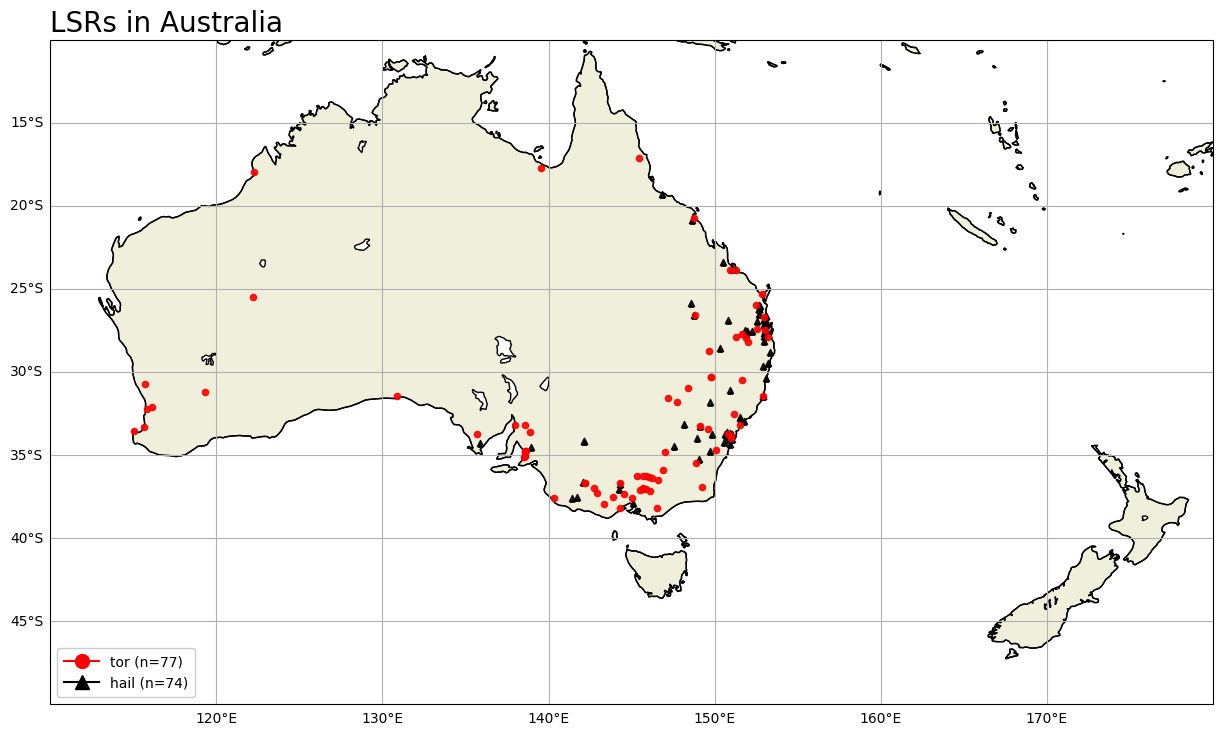

In [5]:
# quick test of all points in Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
filename = 'Australia_LSR.png'
plot_title = 'LSRs in Australia'

aus_data = extract_lsr_data_australia(date=None)  # Get all reports

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, aus_data, filename, plot_title)
    

In [6]:
def practically_perfect_hindcast_aus(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constants = {'hail': 15, 'tor': 5}
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
        report_constants: A dictionary mapping report types to their respective values for the PPH grid. Default is {'hail': 15, 'tor': 5}.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = extract_lsr_data_australia(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Create a grid covering Australia
    lat_min, lat_max = -50, -10.0   
    lon_min, lon_max = 110, 180  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # extract reports for TOR and HAIL separately to handle the underreporting
    for report_type in report_constants.keys():
        # Filter the dataframe for the current report type
        df2 = df[df['report_type'] == report_type]

        # Extract latitude and longitude from the dataframe
        lats = df2["Latitude"].astype(float)
        lons = df2["Longitude"].astype(float)

        # Mark grid cells that contain reports
        for lat, lon in zip(lats, lons):
            # Find the nearest grid indices
            lat_idx = np.abs(grid_lats - lat).argmin()
            lon_idx = np.abs(grid_lons - lon).argmin()
            grid[lat_idx, lon_idx] = report_constants[report_type]  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
    if return_reports:
        return (pph, df)
    return pph

{'hail': 2, 'tor': 2}


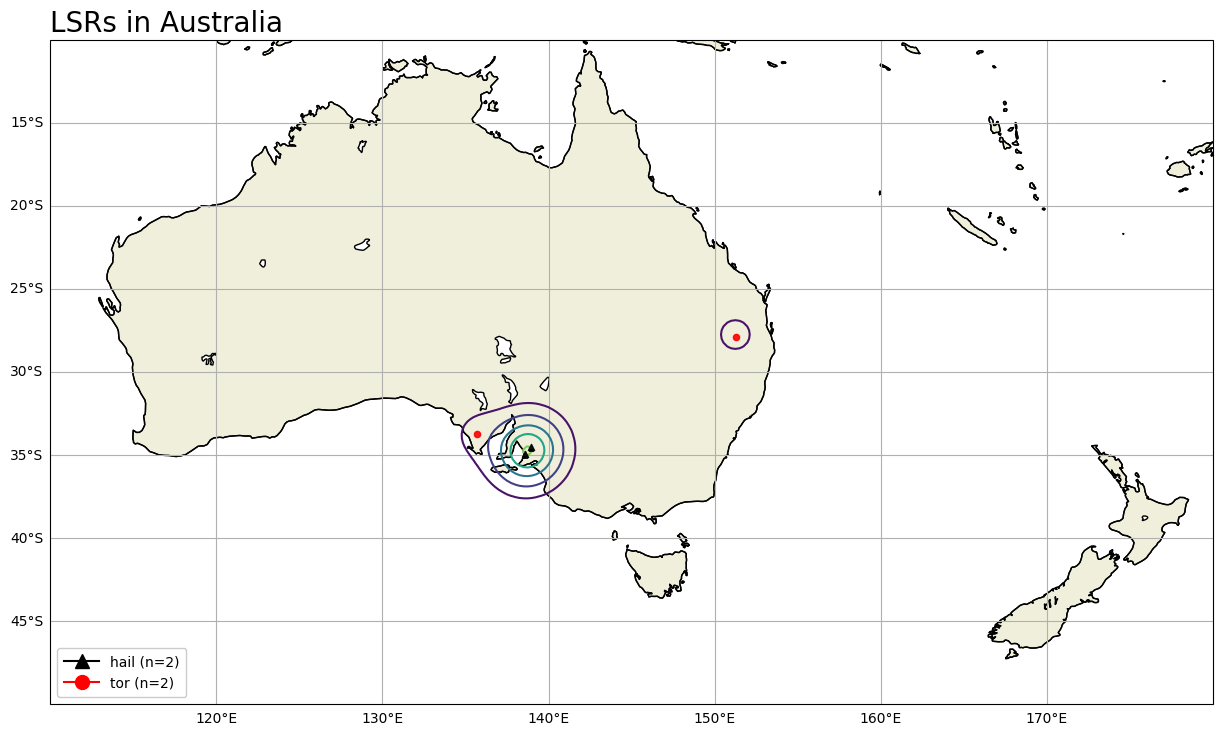

In [7]:
# plot a specific test case with PPH to verify that it is working well with the chosen weights
date = pd.Timestamp(2021,10,28,00,00)
pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

start_date = date - pd.Timedelta(days=0.5)    
end_date = date + pd.Timedelta(days=0.5)
daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
# plot PPH and the cases
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph_aus)

#print(pph_aus)
#pph_aus.plot()

In [8]:
# look through every date in the australia data print the case count for all non-zero dates
aus_data = extract_lsr_data_australia(date=None)  # Get all reports

# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
     # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
    if len(daily_data) >= 2:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

        filename = f"Australia_LSR_{date.strftime('%Y-%m-%d')}.png"
        plot_title = f"LSRs in Australia for {date.strftime('%Y-%m-%d')}"

        # compute PPH on this date
        pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

        # plot PPH and the cases
        plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph_aus)
        plt.close()

        

2020-01-20: 2 reports - {'hail': 2}
{'hail': 2}
2020-04-03: 2 reports - {'tor': 2}
{'tor': 2}
2020-05-31: 3 reports - {'tor': 3}
{'tor': 3}
2020-09-25: 2 reports - {'tor': 2}
{'tor': 2}
2020-10-31: 2 reports - {'hail': 2}
{'hail': 2}
2020-12-05: 2 reports - {'tor': 2}
{'tor': 2}
2021-09-30: 6 reports - {'hail': 4, 'tor': 2}
{'hail': 4, 'tor': 2}
2021-10-14: 6 reports - {'hail': 4, 'tor': 2}
{'hail': 4, 'tor': 2}
2021-10-18: 5 reports - {'hail': 4, 'tor': 1}
{'hail': 4, 'tor': 1}
2021-10-19: 2 reports - {'hail': 1, 'tor': 1}
{'hail': 1, 'tor': 1}
2021-10-28: 4 reports - {'hail': 2, 'tor': 2}
{'hail': 2, 'tor': 2}
2021-12-03: 2 reports - {'hail': 2}
{'hail': 2}
2021-12-09: 2 reports - {'hail': 2}
{'hail': 2}
2022-01-15: 2 reports - {'hail': 1, 'tor': 1}
{'hail': 1, 'tor': 1}
2022-03-04: 2 reports - {'hail': 2}
{'hail': 2}
2022-12-08: 2 reports - {'hail': 2}
{'hail': 2}
2023-02-14: 3 reports - {'hail': 3}
{'hail': 3}
2023-12-12: 2 reports - {'tor': 2}
{'tor': 2}
2023-12-25: 2 reports - {'

# Load ERA5

In [12]:
# load ERA-5
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),)

# Craven SIGSVR code (from the US notebook)

In [9]:
def _wrap_metpy_mixed_layer_cape_cin(pressure, temperature, dewpoint):
    cape, cin = metpy.calc.thermo.mixed_layer_cape_cin(
        pressure * metpy.units.units.hPa,
        (temperature - 273.15) * metpy.units.units.degC,
        dewpoint * metpy.units.units.degC,
    )
    return cape.m, cin.m

# Craven, J. P., and H. E. Brooks, 2004: Baseline climatology
# of sounding derived parameters associated with deep moist convection. Natl. Wea. Digest, 28, 13-24.
def craven_sigsvr(ds: xr.Dataset) -> xr.DataArray:
    """Compute the Craven Significant Severe Parameter. Values over ~22,500 m3/s3 indicate higher
    likelihood of severe convection, hail, and tornadoes.
    Args:
        ds: An xarray Dataset containing winds, temperature, and humidity (relative and/or specific).

    Returns:
        sigsvr: An xarray DataArray containing the Craven Significant Severe Parameter in m3/s3.
    """
    # Compute estimated 0-6 km shear from Lepore et al 2021
    shear_0_6_km = np.sqrt(
        (ds["eastward_wind"].sel(level=500) - ds["surface_eastward_wind"]) ** 2
        + (ds["northward_wind"].sel(level=500) - ds["surface_northward_wind"]) ** 2
    )
    pressure_levels = ds.isel(level=slice(None, None, -1)).assign(pressure=lambda x: x['level'])['pressure']
    
    temperature = ds["air_temperature"]

    if "dewpoint_temperature" in ds.variables:
        dewpoint_temperature = (
            ds["dewpoint_temperature"]
        )
    else:
        raise ValueError("No humidity variable found in dataset")
    # Make sure all inputs have the same level coordinate by selecting with pressure_levels
    mlcape, _ = xr.apply_ufunc(
        _wrap_metpy_mixed_layer_cape_cin,
        pressure_levels,
        temperature.sel(level=pressure_levels),
        dewpoint_temperature.sel(level=pressure_levels),
        input_core_dims=[["level"], ["level"], ["level"]],
        output_core_dims=[[], []],
        vectorize=True,
        output_dtypes=[float, float],
    )
    sigsvr = mlcape * shear_0_6_km
    return sigsvr

In [13]:
# test ERA5 over australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180

date = pd.Timestamp(2021,10,28,00,00)

# Create a DataArray with latitude and longitude coordinates
# Latitude range: -50 to -10 with 0.25 degree resolution
# Longitude range: 110 to 180 with 0.25 degree resolution

# Calculate the number of points for each dimension
lat_points = int(((-10) - (-50)) / 0.25) + 1  # From -50 to -10
lon_points = int((180 - 110) / 0.25) + 1      # From 110 to 180

# Create coordinate arrays
lats = np.linspace(-50, -10, lat_points)
lons = np.linspace(110, 180, lon_points)

# Create an empty data array filled with zeros
data = np.zeros((len(lats), len(lons)))

# Create the xarray DataArray
new_australia_dataarray = xr.DataArray(
    data=data,
    dims=["latitude", "longitude"],
    coords={
        "latitude": lats,
        "longitude": lons
    },
    name="example_data"
)
#print(new_australia_dataarray)

era5_test = era5.sel(time=date,latitude=new_australia_dataarray.latitude, longitude=new_australia_dataarray.longitude, method='nearest')
era5_test = era5_test.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                            '10m_v_component_of_wind': 'surface_northward_wind',
                            'u_component_of_wind': 'eastward_wind',
                            'v_component_of_wind': 'northward_wind',
                            'temperature': 'air_temperature',
                            })
era5_test = era5_test[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
era5_test = era5_test.compute()
era5_test['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(era5_test['level'] * metpy.units.units.hPa, era5_test['specific_humidity'] * metpy.units.units.dimensionless)

era5_craven_test = craven_sigsvr(era5_test)

<xarray.DataArray 'example_data' (latitude: 161, longitude: 281)> Size: 362kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(161, 281))
Coordinates:
  * latitude   (latitude) float64 1kB -50.0 -49.75 -49.5 ... -10.5 -10.25 -10.0
  * longitude  (longitude) float64 2kB 110.0 110.2 110.5 ... 179.5 179.8 180.0


<xarray.DataArray ()> Size: 8B
array(1.13664993e+09)
Coordinates:
    time     datetime64[ns] 8B 2021-10-28
    level    int64 8B 500
{'hail': 2, 'tor': 2}


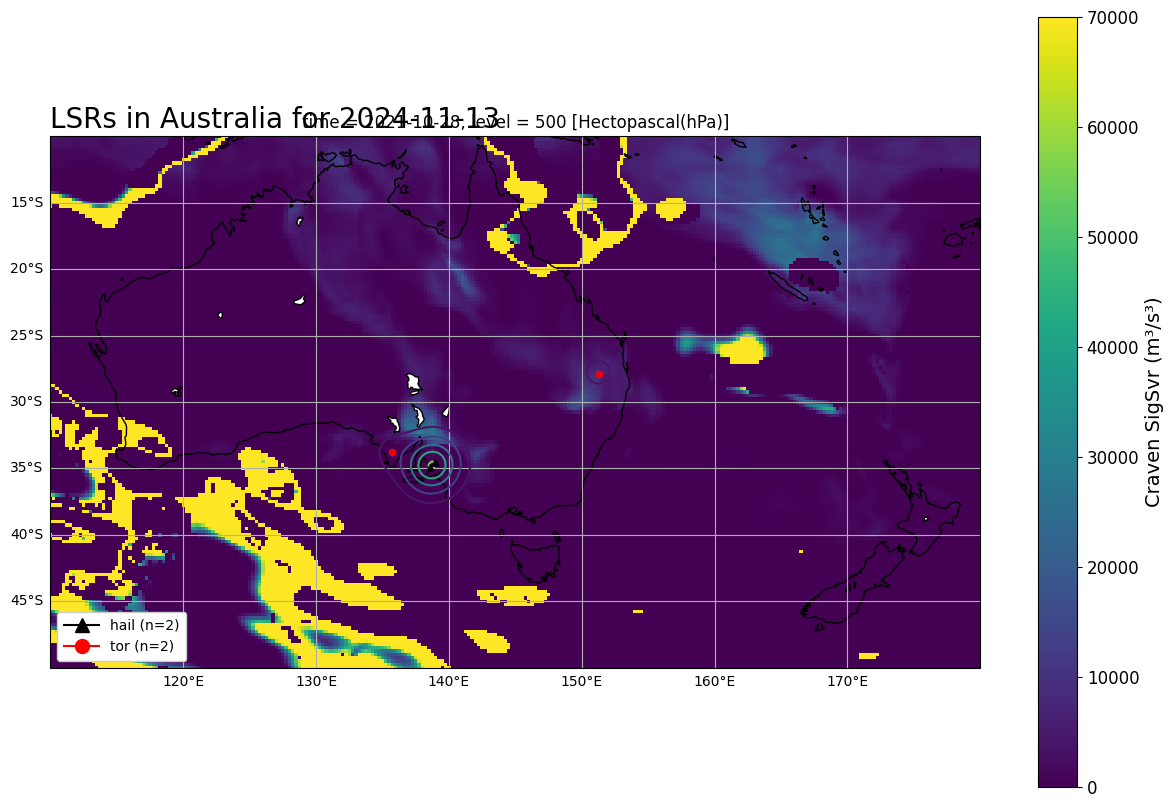

In [15]:
#era5_craven_test.plot()
#print(era5_craven_test)
date = pd.Timestamp(2021,10,28,00,00)

pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

start_date = date - pd.Timedelta(days=0.5)    
end_date = date + pd.Timedelta(days=0.5)
daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]


plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph_aus, sigsvr=era5_craven_test)
